# How To Be a Successful Host? - Group ID: 38

Group Members:

Abidin Gökçekaya 25337

Ahmet Mert Kolabaş 25363

## Introduction

We are analyzing the given Airbnb data and other datasets we found on the internet to understand the main characteristics of successful and highly recommended hosts. Thanks to the information we have obtained, we are trying to analyze the differences between the places that are unsuccessful hosts and successful hosts. Through this analysis, we aim to find out the reason for the success different and try to find specific solutions to recommend what unsuccessful hosts can do better. First, to understand which location is successful or unsuccessful, we use a data frame from Airbnb's site which involves the user ratings for the hosts. After that, we obtain a single data frame by matching their ids. Then we analyze the data and accepted the hosts which are equal or higher than 90 points as successful hosts. Thanks to this comparison, we try to find out why these hosts are successful by using external datasets which are air quality, arrest data, hotel locations, taxi trips, and theater locations.

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

path_prefix = "/content/drive/My Drive/CS210/Proje"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import join
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

In [0]:
fname = "AB_NYC_2019.csv"
maindf = pd.read_csv(join(path_prefix, fname))

fname = "Arrest_Data.csv"
arrestdf = pd.read_csv(join(path_prefix, fname))

fname = "Theater_Loc.csv"
thdf = pd.read_csv(join(path_prefix, fname))

fname = "subway.csv"
subdf = pd.read_csv(join(path_prefix, fname))

fname = "listingsairbnb.csv"
listdf = pd.read_csv(join(path_prefix, fname))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Problem Definition

We aim to find successful hosts and why they are successful. That way we can make recommendations to bad hosts how to get better. We will use feature engineering and classification machine learning algorithms like Knn and random forest to construct a classifier. We will extract important features form random forest implementation.

### Utilized Datasets


####Nyc Airbnb data
Thanks to this data, we have learned the locations of Airbnb hosts around New York City. Then we created a heat map using this data and analyzed the importance of other data on this map.

Link: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

Shape: NYC Airbnb (48895, 16)

####Listings data
This data contains listings of the  Airbnb hosts. We merged this data set with the NYC Airbnb data set according to their ids. Thanks to this merged dataset, we obtained the rating points of the Airbnb hosts. The rating points we obtained were very effective in our success comparison.

Link: http://data.insideairbnb.com/united-states/ny/new-york-city/2020-04-08/visualisations/listings.csv

Shape: listings (50796, 106)

####Subway data
 Thanks to the Subway data, we reached the number and location of the Subway stations in the regions. Through this information, we have analyzed the transportation possibilities of the regions where the Airbnb hosts are located. The information we obtained in our research has shown us how important transportation is.

Link: https://data.cityofnewyork.us/Transportation/Subway-Entrances/drex-xx56

Shape: subway (1928, 4)

####Theater data

By using the theater data, we have seen the number of social activities in the regions where the Airbnb hosts are located. After that by using the information we have obtained, we investigated how much the amount of activity in the regions affects the success of the Airbnb hostesses.

Link: https://data.cityofnewyork.us/Recreation/Theaters/kdu2-865w

Shape: theater (117, 6)

####Arrest Nyc Open Data
This data showed us the number of crimes in Newyork City areas and gave the specific names of the crimes. This information gave us the crime rates of the regions where Airbnb offices are located. Later, thanks to our analysis, we realized that the crime rate was inversely proportional to the Airbnb hostesses' success percentages.

Shape: arrest (214617, 6)

#### Merge
---
To identify which hosts are successful, we used a database that contains user scores. We merged the main database and the one with user scores based on the 'id' column. This will be our main data from now on.

In [0]:
df_merged = pd.merge(listdf, maindf, on='id')
df_merged.drop(df_merged.columns.difference(['id', 'host_response_rate','host_acceptance_rate', 'host_is_superhost', 'neighbourhood_group', 'host_total_listings_count', 'host_identity_verified', 'latitude_y', 'longitude_y', 'property_type', 'room_type_y','number_of_reviews_y','review_scores_rating','reviews_per_month_y','price_y']), 1, inplace=True)
df_merged.head(4)

id host_response_rate  ... number_of_reviews_y reviews_per_month_y
0  2595                87%  ...                  45                0.38
1  3831                83%  ...                 270                4.64
2  5099                NaN  ...                  74                0.59
3  5121                NaN  ...                  49                0.40

[4 rows x 15 columns]

#### Clearing NaN values in scores
We deleted NaN values in scores because we can't evaluate if they are good or not by another value.

In [0]:
df_merged = df_merged.dropna(subset=["review_scores_rating"])
df_merged.head()

id host_response_rate  ... number_of_reviews_y reviews_per_month_y
0  2595                87%  ...                  45                0.38
1  3831                83%  ...                 270                4.64
2  5099                NaN  ...                  74                0.59
3  5121                NaN  ...                  49                0.40
4  5178                90%  ...                 430                3.47

[5 rows x 15 columns]

We dropped zero prices because it means they didn't open any listings this year. We don't want inactive hosts.

In [0]:
df_merged = df_merged[df_merged.price_y != 0].copy()

Our review score bar chart. We made this to illustrate the distribution.

In [0]:
plt.hist(df_merged["review_scores_rating"], bins=20, rwidth=0.6)
plt.show

<function matplotlib.pyplot.show>

## Data Exploration

### Classification
We classified hosts based on user scores. We distributed them into 4 categories: Successful, Good, Okey, Bad. We chose boundaries based on the build-up in certain point ranges. We tried to choose the best hosts among others. Our boundary for successful hosts is 99 points. Even though 99 points are very high, there are still over eight thousand hosts.

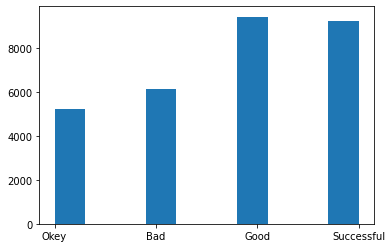

In [0]:
def success(row):
  if row["review_scores_rating"] <= 90:
    return "Bad"
  if 90 <= row["review_scores_rating"] <= 94:
    return "Okey"
  if 95 <= row["review_scores_rating"] <= 98:
    return "Good"
  if 99 <= row["review_scores_rating"] <=100 :
    return "Successful"


df_merged["Success"] = df_merged.apply(success, axis = 1)
plt.hist(df_merged["Success"])
plt.show()

### Base Heat Map
We split the data frame based on our criteria. Our main heatmap is the heatmap of successful hosts. We aim to compare this heatmap with our other datasets to find a correlation.

In [0]:
import folium

success_df = df_merged[df_merged.Success == 'Successful']
good_df = df_merged[df_merged.Success == 'Good']
okey_df = df_merged[df_merged.Success == 'Okey']
bad_df = df_merged[df_merged.Success == 'Bad']

success_df.head(3)

id host_response_rate  ... reviews_per_month_y     Success
46  15396               100%  ...                0.12  Successful
48  16326               100%  ...                1.33  Successful
51  16458                NaN  ...                0.16  Successful

[3 rows x 16 columns]

In [0]:
lat = success_df["latitude_y"].mean()
lng = success_df["longitude_y"].mean()

m = folium.Map(location=[lat, lng], zoom_start=12, tiles = "Stamen Terrain")

loc=success_df[['latitude_y','longitude_y']].values

In [0]:
from folium import plugins

In [0]:
sheat = folium.Map(location=[lat, lng], zoom_start=11, tiles = "Stamen Terrain")

sheat.add_child(plugins.HeatMap(loc, radius=15))

###Subway Entrances Dataset
  At first, we organized a dataset to create latitude and longitude columns. Then we used these columns to visualize them o our base heatmap to find a correlation. It seems that the path and entrances of subways affect how density distributed in new york city. It has a clear correlation between successful hosts and subway lines.

In [0]:
def lati(row):
  x = row['the_geom'].split()
  y = x[2]
  return float(y[:-1])

def longt(row):
  x = row['the_geom'].split()
  y = x[1]
  return float(y[1:])  

subdf["latitude"] = subdf.apply(lati, axis = 1)
subdf["longitude"] = subdf.apply(longt, axis = 1)

subdf.drop(subdf.columns.difference(['NAME','latitude','longitude','the_geom']), 1, inplace=True)

subdf.head()

NAME  ...  longitude
0  Birchall Ave & Sagamore St at NW corner  ... -73.868356
1  Birchall Ave & Sagamore St at NE corner  ... -73.868213
2  Morris Park Ave & 180th St at NW corner  ... -73.873499
3  Morris Park Ave & 180th St at NW corner  ... -73.872892
4        Boston Rd & 178th St at SW corner  ... -73.879623

[5 rows x 4 columns]

In [0]:
sheat2 = folium.Map(location=[lat, lng], zoom_start=11, tiles = "Stamen Terrain")
sheat2.add_child(plugins.HeatMap(loc, radius=15))

loc_sub=subdf[['latitude','longitude']].values

for i in loc_sub:
  folium.CircleMarker(location=i, radius=1, color="black").add_to(sheat2)
sheat2

###Theater Locations Dataset
  We used this dataset to understand the effect of cultural events on the locations of successful hosts. Unfortunately, we only have theater locations for manhattan. Like subway entrances, we organized the dataset to obtain latitude and longitude that we need for map comparison.
  It seems that cultural events explain the density in the downtown area. It can be said that the density of successful hosts in the downtown area could be somewhat related to theater locations.

In [0]:
def lati(row):
  x = row['the_geom'].split()
  y = x[2]
  return float(y[:-1])

def longt(row):
  x = row['the_geom'].split()
  y = x[1]
  return float(y[1:])  

thdf["latitude"] = thdf.apply(lati, axis = 1)
thdf["longitude"] = thdf.apply(longt, axis = 1)

thdf.drop(thdf.columns.difference(['NAME','latitude','longitude','ADDRESS1','ZIP','the_geom']), 1, inplace=True)

thdf.head()

the_geom  ...  longitude
0  POINT (-73.99061840882582 40.75985115447559)  ... -73.990618
1   POINT (-73.9881059525377 40.76047123447081)  ... -73.988106
2  POINT (-73.97038450260143 40.76339942774153)  ... -73.970385
3   POINT (-73.99332384622063 40.7585366821068)  ... -73.993324
4   POINT (-73.9892143340222 40.75926091219353)  ... -73.989214

[5 rows x 6 columns]

In [0]:
sheat3 = folium.Map(location=[lat, lng], zoom_start=11, tiles = "Stamen Terrain")
sheat3.add_child(plugins.HeatMap(loc, radius=15))

loc_th=thdf[['latitude','longitude']].values

for i in loc_th:
  folium.CircleMarker(location=i, radius=1, color="black").add_to(sheat3)
sheat3

###Arrest Locations Dataset
With this dataset, we tried to understand the correlation between crime locations and successful hosts. The dataset contains every arrest made in New York in 2019. We had to split the dataset because it was very large to process in Google Colab. We took the first part to illustrate the correlation. It seems like there aren't any strict correlation between arrest locations and successful hosts. Crime does not stop people to choose these hosts.

In [0]:
arrestdf.drop(arrestdf.columns.difference(['ARREST_DATE','Latitude','Longitude','PD_DESC','ARREST_DATE','OFNS_DESC','AGE_GROUP']), 1, inplace=True)
arrestdf_split = np.array_split(arrestdf, 50)
arrestdf_split[0].head()

ARREST_DATE                        PD_DESC  ...   Latitude  Longitude
0  12/31/2019          IMPAIRED DRIVING,DRUG  ...  40.841085 -73.939769
1  12/31/2019      FRAUD,UNCLASSIFIED-FELONY  ...  40.596012 -73.742116
2  12/31/2019  HOMICIDE, NEGLIGENT, VEHICLE,  ...  40.789803 -73.952289
3  12/31/2019             CRIMINAL MIS 2 & 3  ...  40.645023 -74.077217
4  12/31/2019                      ASSAULT 3  ...  40.787875 -73.928182

[5 rows x 6 columns]

In [0]:
sheat4 = folium.Map(location=[lat, lng], zoom_start=11, tiles = "Stamen Terrain")
sheat4.add_child(plugins.HeatMap(loc, radius=15))

loc_arr=arrestdf_split[1][['Latitude','Longitude']].values

for i in loc_arr:
  folium.CircleMarker(location=i, radius=1, color="black").add_to(sheat4)
sheat4

Output hidden; open in https://colab.research.google.com to view.

## Machine Learning Models


### Knn Implementation


#### Data Cleaning

Organizing our data to fit in machine learning algorithms. We filled Nan values with zeros and transformed string objects to either floats or integers.

In [0]:
df_merged_knn = df_merged.drop(['id','review_scores_rating'],axis=1)
#df_merged_knn = df_merged.drop('property_type',axis=1)
df_merged_knn[["reviews_per_month_y", "host_total_listings_count"]] = df_merged_knn[["reviews_per_month_y", "host_total_listings_count"]].fillna(0)

In [0]:
df_merged_knn[["host_response_rate"]] = df_merged_knn[["host_response_rate"]].fillna("0")
df_merged_knn[["host_acceptance_rate"]] = df_merged_knn[["host_response_rate"]].fillna("0")

In [0]:
def percentage(row):
  if(row["host_response_rate"] != "0"):
    str1 = str(row["host_response_rate"])[:-1]
    str2 = float(str1)
    str2 = str2/100
    str3 = str(str2)
    return str3
  else:
    return "0"

def percentage2(row):
  if(row["host_acceptance_rate"] != "0"):
    str1 = str(row["host_acceptance_rate"])[:-1]
    str2 = float(str1)
    str2 = str2/100
    str3 = str(str2)
    return str3
  else:
    return "0"    

df_merged_knn["host_response_rate"] = df_merged_knn.apply(percentage, axis = 1)
df_merged_knn["host_acceptance_rate"] = df_merged_knn.apply(percentage2, axis = 1)

In [0]:
df_merged_knn["host_response_rate"] = df_merged_knn["host_response_rate"].astype(float)
df_merged_knn["host_acceptance_rate"] = df_merged_knn["host_response_rate"].astype(float)

#### Encoding

We encoded our categorical data based on their ordinality. We used label encoding for ordinal data. We used one-hot encoding for non-ordinal categorical data to avoid wrong implementations like one category is higher than others while this isn't the case.

In [0]:
def Encode(df_merged_knn):
    for column in df_merged_knn.columns[df_merged_knn.columns.isin(['host_is_superhost','host_identity_verified'])]:
        df_merged_knn[column] = df_merged_knn[column].factorize()[0]
    return df_merged_knn
#'neighbourhood_group'  'room_type_y  ,'property_type'
df_merged_en = Encode(df_merged_knn.copy())
df_merged_en.head(4)

host_response_rate  host_acceptance_rate  ...  reviews_per_month_y  Success
0                0.87                  0.87  ...                 0.38     Okey
1                0.83                  0.83  ...                 4.64      Bad
2                0.00                  0.00  ...                 0.59      Bad
3                0.00                  0.00  ...                 0.40      Bad

[4 rows x 14 columns]

In [0]:
def encode(row):
    if(row["Success"] == "Bad"):
      return "0"
    elif(row["Success"] == "Okey"):
      return "1"
    elif(row["Success"] == "Good"):
      return "2"
    else:
      return "3"

df_merged_en["Success"] = df_merged_en.apply(encode, axis = 1)
df_merged_en["Success"] = df_merged_en["Success"].astype(int)

In [0]:
df_merged_en = pd.get_dummies(df_merged_en,prefix=['neighbourhood_group'], columns = ['neighbourhood_group'])
df_merged_en = pd.get_dummies(df_merged_en,prefix=['room_type_y'], columns = ['room_type_y'])
df_merged_en = pd.get_dummies(df_merged_en,prefix=['property_type'], columns = ['property_type'])
df_merged_en.head()

host_response_rate  ...  property_type_Villa
0                0.87  ...                    0
1                0.83  ...                    0
2                0.00  ...                    0
3                0.00  ...                    0
4                0.90  ...                    0

[5 rows x 49 columns]

We took logarithm of price column to make values closer to each other.

In [0]:
df_merged_en['price_y'] = np.log(df_merged_en['price_y']+1)
df_merged_en.head(2)

host_response_rate  ...  property_type_Villa
0                0.87  ...                    0
1                0.83  ...                    0

[2 rows x 49 columns]

#### Hypermeter Tuning for Knn

We made graphs for different distance calculation formulas and different k values. We tried to get the highest accuracy score based on these graphs.

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# separate features and the target column
X = df_merged_en.drop("Success", axis=1)
y = df_merged_en["Success"]

# 80% for training and 20% for testing-validation
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.20, random_state=42)
# 10% validation, 10% test
X_test, X_val, y_test, y_val = train_test_split(X_remaining, y_remaining, test_size=0.50, random_state=42)

In [0]:


K_range = np.arange(1, 50)
accuracy_list1 = []

for k in K_range:
  # create a new model with current K
  knn = KNeighborsClassifier(k, metric="euclidean")
  # fit training data
  knn.fit(X_train, y_train)
  # predict the validation data
  y_pred = knn.predict(X_val)
  # obtain the accuracy value
  accuracy = accuracy_score(y_val, y_pred)
  accuracy_list1.append(accuracy)

plt.figure(figsize=(12, 6))  
plt.plot(K_range, accuracy_list1, color='black', linestyle='dashed', marker='o',  
         markerfacecolor='red', markersize=10)
plt.title('Accuracy of the Validation w/ K -- Euclidean')  
plt.xlabel('K')  
plt.ylabel('Accuracy')
plt.xticks(K_range)
#plt.grid()
plt.show()

In [0]:
accuracy_list2 = []

for k in K_range:
  # create a new model with current K
  knn = KNeighborsClassifier(k, metric="cityblock")
  # fit training data
  knn.fit(X_train, y_train)
  # predict the validation data
  y_pred = knn.predict(X_val)
  # obtain the accuracy value
  accuracy = accuracy_score(y_val, y_pred)
  accuracy_list2.append(accuracy)

plt.figure(figsize=(12, 6))  
plt.plot(K_range, accuracy_list2, color='black', linestyle='dashed', marker='o',  
         markerfacecolor='red', markersize=10)
plt.title('Accuracy of the Validation w/ K -- Cityblock')  
plt.xlabel('K')  
plt.ylabel('Accuracy')
plt.xticks(K_range)
#plt.grid()
plt.show()

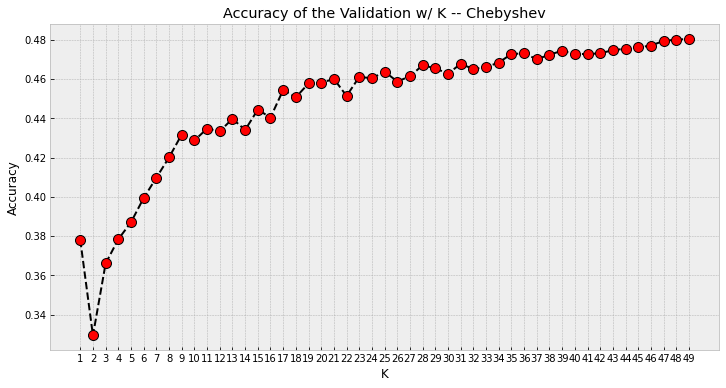

In [0]:
accuracy_list3 = []

for k in K_range:
  # create a new model with current K
  knn = KNeighborsClassifier(k, metric="chebyshev")
  # fit training data
  knn.fit(X_train, y_train)
  # predict the validation data
  y_pred = knn.predict(X_val)
  # obtain the accuracy value
  accuracy = accuracy_score(y_val, y_pred)
  accuracy_list3.append(accuracy)

plt.figure(figsize=(12, 6))  
plt.plot(K_range, accuracy_list3, color='black', linestyle='dashed', marker='o',  
         markerfacecolor='red', markersize=10)
plt.title('Accuracy of the Validation w/ K -- Chebyshev')  
plt.xlabel('K')  
plt.ylabel('Accuracy')
plt.xticks(K_range)
#plt.grid()
plt.show()

It seems likeour highest score is with K=44 and cityblock formula.

In [0]:
max(accuracy_list1)

0.48749583194398133

In [0]:
max(accuracy_list2)

0.49783261087029007

In [0]:
max(accuracy_list3)

0.48049349783261086

#### Accuracy Scores with Standardization

We measured accuracy scores with and without applying standardization. It seems like standardization is not contributing to our project.

In [0]:
knn = KNeighborsClassifier(44, metric="cityblock")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
accuracy

0.49783261087029007

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [0]:
knn = KNeighborsClassifier(44, metric="cityblock")
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_val_scaled)
accuracy = accuracy_score(y_val, y_pred)
accuracy

0.47382460820273425

In [0]:
knn = KNeighborsClassifier(44, metric="cityblock")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.4853235490326885

In [0]:
knn = KNeighborsClassifier(44, metric="cityblock")
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.4786524349566378

### Random Forest Implementation

We implemented random forest classifier as our second model. We tried to optimize our parameters with Grid Search Cross-Validation. We also implemented decision tree to show how advantageous to implement random forest instead.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state = 1, n_estimators = 10, min_samples_split = 1)

In [0]:
from sklearn.model_selection import GridSearchCV
n_estimators = [10,25]
max_depth = [5, 8, 15, None]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 10, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:  6.0min finished


#### Best Parameters

In [0]:
gridF.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=15, n_estimators=25,
                       random_state=1)

In [0]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#Decision Tree Training
model_dt = tree.DecisionTreeClassifier(max_depth=15, min_samples_leaf=15, random_state=1)
model_dt.fit(X_train, y_train)

#Random Forest Training(With our optimized parameters)
model_rf = RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=25,
                       random_state=1)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=15, n_estimators=25,
                       random_state=1)

#### Decision Tree vs Random Forest

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

#Decision Tree Testing
dt_predictions = model_dt.predict(X_test)
dt_acc = accuracy_score(y_test, dt_predictions)

rf_predictions = model_rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_predictions)

print("Decision Tree Accuracy:"+str(dt_acc))
print("Random Forest Accuracy:"+str(rf_acc))

Decision Tree Accuracy:0.4679006169751542
Random Forest Accuracy:0.5259296314824079


#### Feature Importances

This part is very important in our project. We are going to extract the most important features of successful hosts. This way we can understand why they are preforming better.

In [0]:
importances = gridF.best_estimator_.feature_importances_

#create a feature list from the original dataset (list of columns)
feature_list = list(X.columns)

#create a list of tuples
feature_importance= sorted(zip(importances, feature_list), reverse=True)

#create two lists from the previous list of tuples
df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df['importance'])
feature= list(df['feature'])

#see df
print(df)

    importance                               feature
0     0.238333                   number_of_reviews_y
1     0.151153                   reviews_per_month_y
2     0.133106                     host_is_superhost
3     0.076433                           longitude_y
4     0.075524                            latitude_y
5     0.069467                               price_y
6     0.059694             host_total_listings_count
7     0.045954                  host_acceptance_rate
8     0.042556                    host_response_rate
9     0.013135                host_identity_verified
10    0.009636               property_type_Apartment
11    0.008712           room_type_y_Entire home/apt
12    0.008556              room_type_y_Private room
13    0.008102         neighbourhood_group_Manhattan
14    0.007940          neighbourhood_group_Brooklyn
15    0.006460                   property_type_House
16    0.006059            neighbourhood_group_Queens
17    0.005773             property_type_Condo

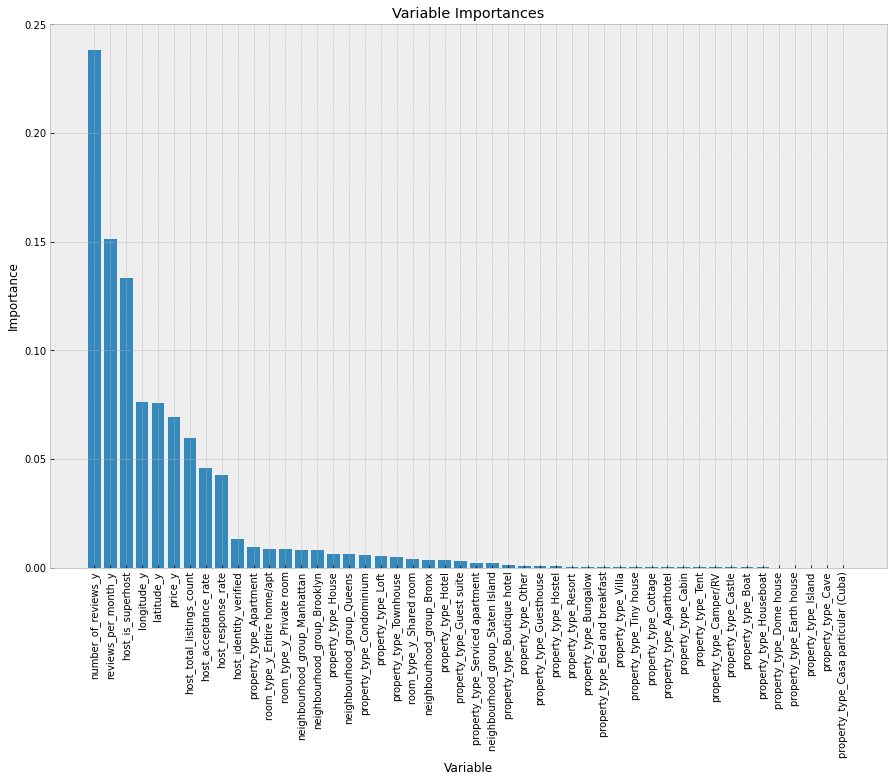

In [0]:
# Set the style
plt.style.use('bmh')
# list of x locations for plotting
x_values = list(range(len(featureImp)))

# Make a bar chart
plt.figure(figsize=(15,10))
plt.bar(x_values, importance, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### Results & Discussion

Throughout our project, we deployed two machine learning algorithms to further analyze our data. Our accuracy scores are like this:

| Model |Accuracy|
| --------- |:----:|
| Knn Validation | 0.49 |
| Knn Test | 0.48 |
| Knn Validation Scaled | 0.47 |
| Knn Test Scaled | 0.47 |
| Decision Tree | 0.46 |
| Random Forest | 0.52 |

The table shows that the random forest is the best model for our research. Although the Knn model is good for the classification of future data, the random forest is much easier to extract the most important features which are the number one priority for our research. In our opinion, the reason for the scaled parameters did not contribute is the way we cleaned our data. We already made values close to each other in every column by encoding and taking logarithms and so on. As a result, the standardization process only messed with latitude and longitude columns which affected the accuracy in a bad way.

To summarise, the random forest turned out to be the best model due to its accuracy rate and ability to derive the most important features.



## Conclusion

		

In our project, we chose a problem faced by Airbnb hosts and we found several functional solutions by using the open data. In the context of our project, we found the main causes of the problem and found solutions by using different data and machine learning algorithms. The solutions that we found is applicable because the features that affect the success which we obtained from the analysis of data sets are not difficult to change.
 
	

It is clear that the best machine learning model for our research is the random forest. As a result, we are going to evaluate our solutions based on the importance graph that we derived from the random forest model.

In the importance graph, we see that the number of reviews is the most important feature that affects the success of the hosts. This shows us that users want to go to places that have been tried before. Also, the number of comments allows the user to see if the host is reliable. To solve this problem, it shows that hosts should also provide incentives for users to comment. 
 
	

The second most important element is the number of monthly reviews. This factor shows us that the constant change in the number of monthly reviews is more attractive to users because monthly changes are the most important proof of how often the host does business during the period. As a solution to this factor, hosts can act more relevant for the guests to comment. 
 
	

The next factor is to be a super host. There are some conditions to be a super host. These are completing at least 10 trips, completing 3 reservations for a total of at least 100 nights, maintaining a 90% or higher response rate, maintaining a 1% cancellation rate, and having a 4.8 overall rating. When we look at these conditions, they can offer a more comfortable accommodation as a solution because one of the conditions is to provide 100 days of accommodation at least 3 times and a 1% cancellation rate. Moreover, feedbacks received from users to obtain host points are very important. 
 
	

When we look at the graph, we see that the regions are affecting the success of the hosts. For example, in the graph, we see that the hosts in Manhattan and Brooklyn regions are more successful.

When we look at the graph, we see that the number of listing affects the success rate. The listing numbers of the hosts show how often they stay active in the Airbnb environment. To be more successful, they need to list more frequently and also to advertise on more sites and stay up to date. 

The response rate of the hosts to the customers affects the success rate of the hosts because a customer could change his/her mind if a host's response time is too high. As a solution to this problem, hosts need to be online at all hours of the day. 

Finally, one of the other factors in the graphic is if the host identity is verified. The fact that the hosts' ids are verified allows the users to choose these hosts more because they look more reliable and safe. Customers are going to stay at another home so reliability is very important in a host's success.

The advantage of the solutions we obtain is they can be easily done and can offer a precise solution to the problem, thanks to the ratio of the factors we find. The disadvantages of the solutions we find are they require some time to apply, so a long-term commitment should be expected